In [ ]:
# !wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

# # Unzip (adjust paths as needed)
# !unzip coco_val2017.zip -d coco_val2017
# !unzip coco_ann2017.zip -d coco_ann2017

############################################################################

In [14]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

# should be tf > 2.15
# and keras > 3.0.0

2.16.1
3.0.5


In [15]:
from tensorflow import keras
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU

from PIL import Image

from pycocotools.coco import COCO

In [2]:
# Load paths for the COCO dataset annotation files
val_annotation_path = 'coco_ann2017/annotations/instances_val2017.json'

# Define the object classes of interest
classes = ['person']

# Initialize COCO instances for validation set and load relevant data
coco_val = COCO(val_annotation_path)
catIds_val = coco_val.getCatIds(catNms=classes)
imgIds_val = coco_val.getImgIds(catIds=catIds_val)
imgDict_val = coco_val.loadImgs(imgIds_val)

# Print the number of training and validation images and categories
print("number of validation images: ",len(imgIds_val))

# Check the number of files in the validation images directory
print("total number of images in the validation images directory :", len(os.listdir("coco_val2017/val2017/")))

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
number of validation images:  2693
total number of images in the validation images directory : 5000


In [4]:
# !rm -r mask_val_2017/*

In [5]:
# Create a directory for validation masks
!mkdir mask_val_2017

# Generate the masks for validation
for id in imgIds_val:

    file_path = "mask_val_2017/{0:012d}.jpg".format(id)

    # random image
    sampleImgIds = coco_val.getImgIds(imgIds=[id])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve annotations
    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    # Generate masks
    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])

    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

mkdir: mask_val_2017: File exists


In [6]:
class DataPreprocess(keras.utils.Sequence):
    def __init__(self, images_path, masks_path, batch_size, image_size=(128, 128)):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.filenames = self._get_matching_filenames()

    def _get_matching_filenames(self):
        image_ids = {os.path.splitext(f)[0] for f in os.listdir(self.images_path)}
        mask_ids = {os.path.splitext(f)[0] for f in os.listdir(self.masks_path)}
        return sorted(list(image_ids & mask_ids))  # Sorted for consistent order

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for file_id in batch_files:
            img = self._load_image(os.path.join(self.images_path, file_id + '.jpg'))
            mask = self._load_mask(os.path.join(self.masks_path, file_id + '.jpg'))

            if img.shape != (self.image_size[0], self.image_size[1], 3):
                continue  # Skip invalid images

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def _load_image(self, path):
        img = Image.open(path).resize(self.image_size)
        img_array = np.array(img).astype('float32') / 255.0
        return img_array

    def _load_mask(self, path):
        mask = Image.open(path).resize(self.image_size)
        mask_array = np.array(mask).astype('float32') / 255.0
        return mask_array

images_path_val = 'coco_val2017/val2017/'
masks_path_val = 'mask_val_2017/'
batch_size = 8

val_generator = DataPreprocess(images_path_val, masks_path_val, batch_size)

In [7]:
print(len(val_generator))

337


Mask Image Shape: (426, 640)
Main Image Shape: (426, 640, 3)


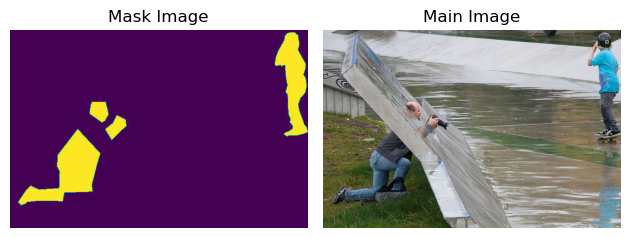

In [8]:
# Get the list of mask filenames
mask_filenames = [filename for filename in os.listdir(masks_path_val) if filename.endswith('.jpg')]

# Assuming the first image in the mask folder is the one to plot
first_mask_filename = mask_filenames[3]
image_filename = os.path.splitext(first_mask_filename)[0] + '.jpg'

# Load and plot the mask image
mask_image = Image.open(os.path.join(masks_path_val, first_mask_filename))
plt.subplot(1, 2, 1)
plt.imshow(mask_image)
plt.title('Mask Image')
plt.axis('off')

# Load and plot the corresponding main image
main_image = Image.open(os.path.join(images_path_val, image_filename))
plt.subplot(1, 2, 2)
plt.imshow(main_image)
plt.title('Main Image')
plt.axis('off')

# Print the shapes of the images
print('Mask Image Shape:', np.array(mask_image).shape)
print('Main Image Shape:', np.array(main_image).shape)

plt.tight_layout()
plt.show()

2025-05-14 15:05:26.597001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


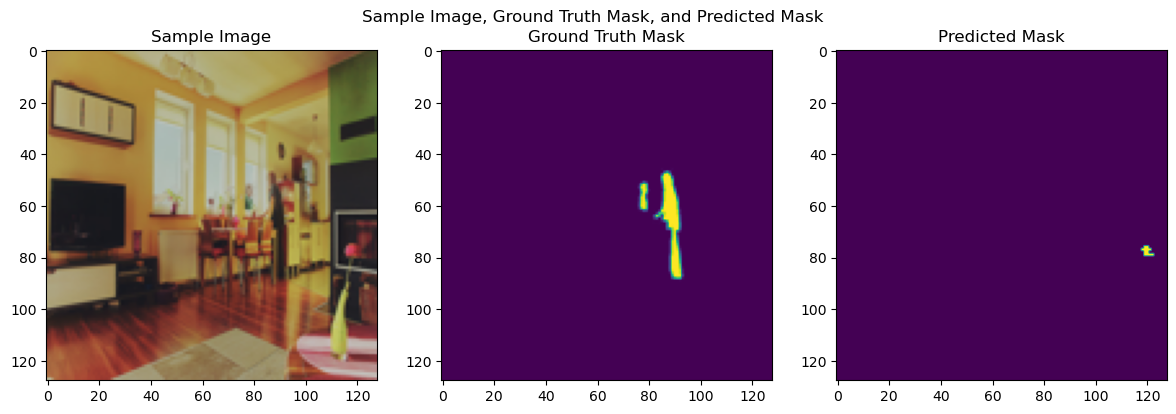

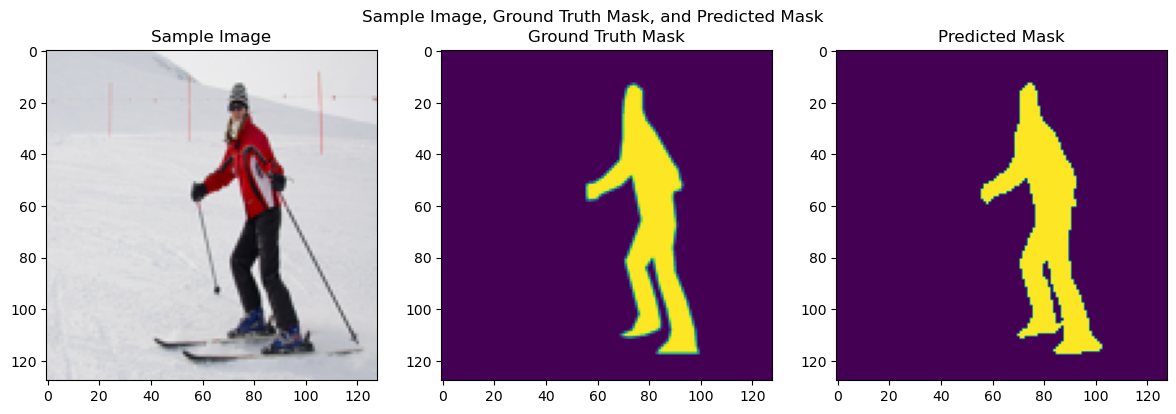

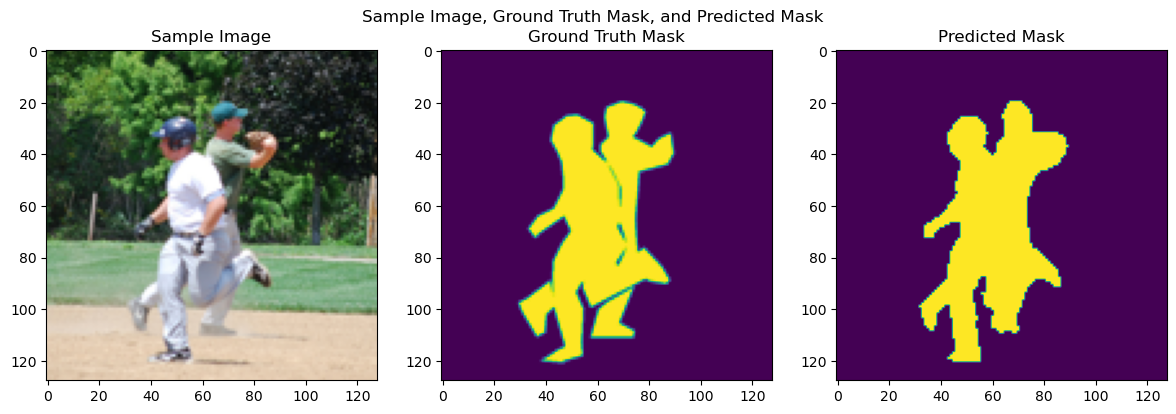

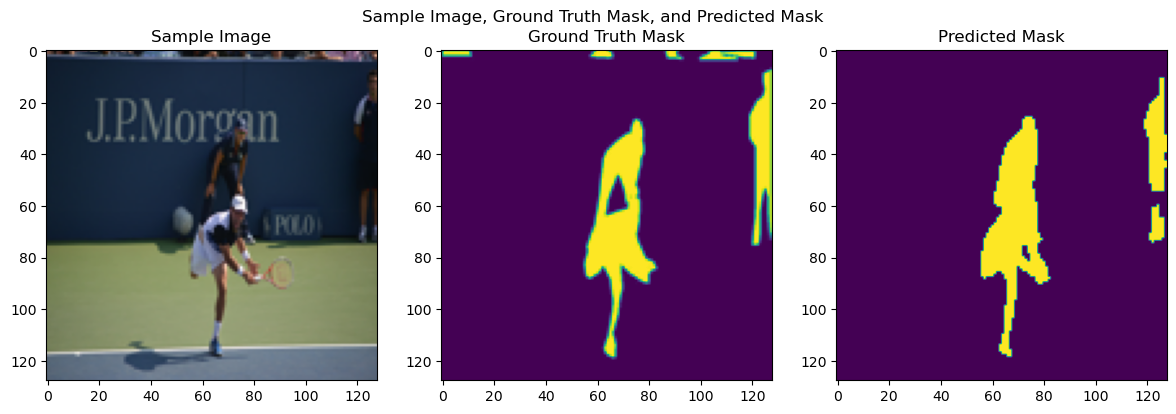

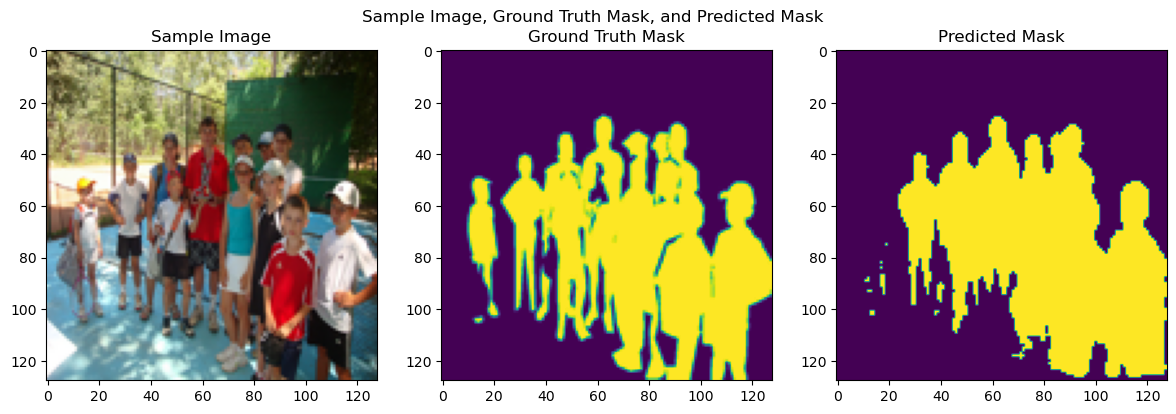

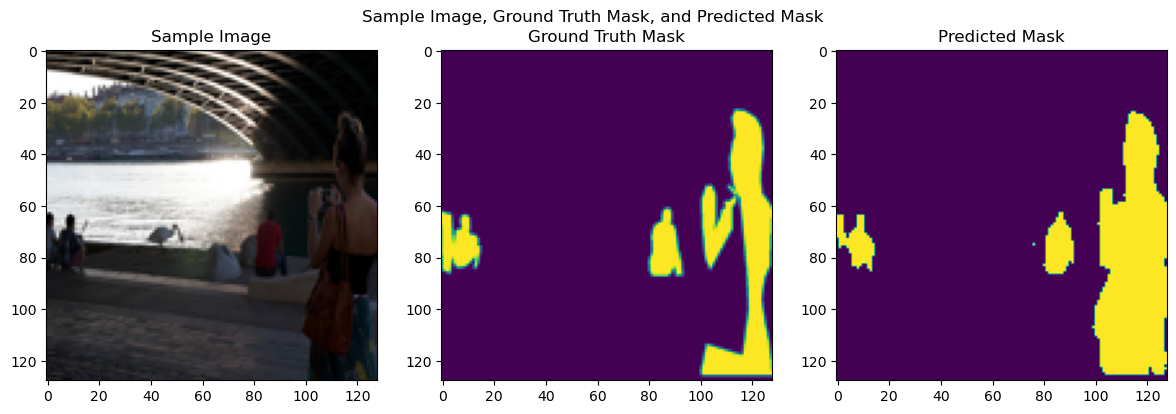

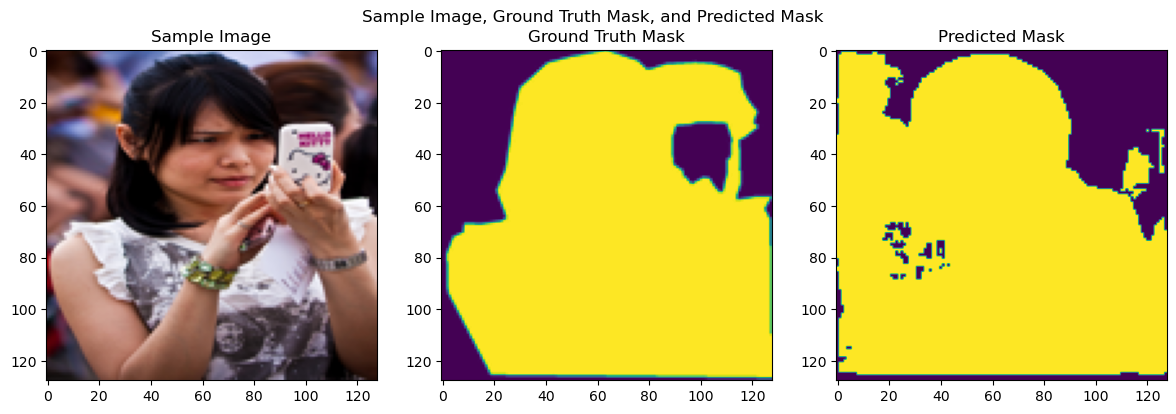

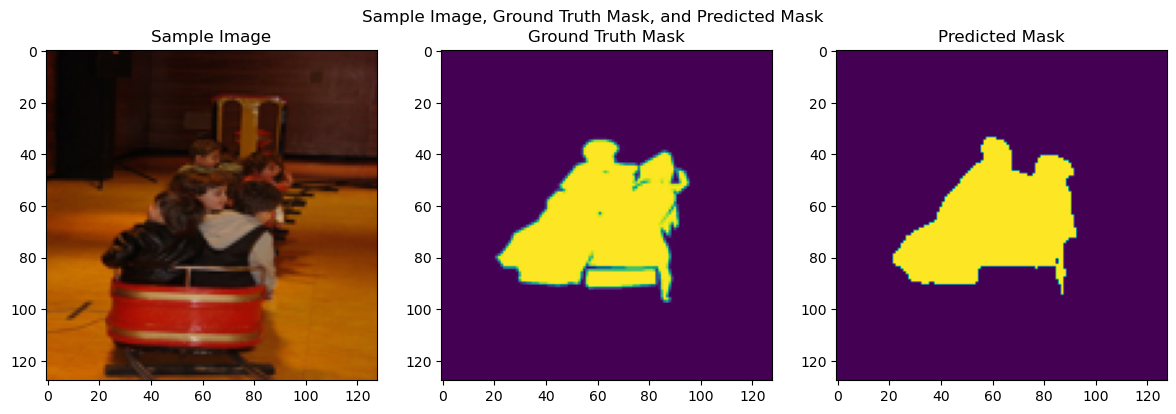

In [10]:
inference_model = load_model('unet_coco_person_segmentation.h5')

# Get a sample batch from the validation data generator
sample_images, sample_masks = (val_generator)[0]

# Generate predictions on the sample batch
predictions = inference_model.predict(sample_images)

# Threshold the predictions (if needed)
threshold = 0.5  # Adjust the threshold as per your requirement
thresholded_predictions = (predictions > threshold).astype(np.uint8)


for idx in range(0, len(sample_images)):
  # Plot the sample image, ground truth mask, and predicted mask
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  # Plot sample image
  axes[0].imshow(sample_images[idx])
  axes[0].set_title('Sample Image')

  # Plot ground truth mask
  axes[1].imshow(sample_masks[idx])
  axes[1].set_title('Ground Truth Mask')

  # Plot predicted mask
  axes[2].imshow(thresholded_predictions[idx])
  axes[2].set_title('Predicted Mask')

  # Set common title for the figure
  fig.suptitle('Sample Image, Ground Truth Mask, and Predicted Mask')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the figure
  plt.show()

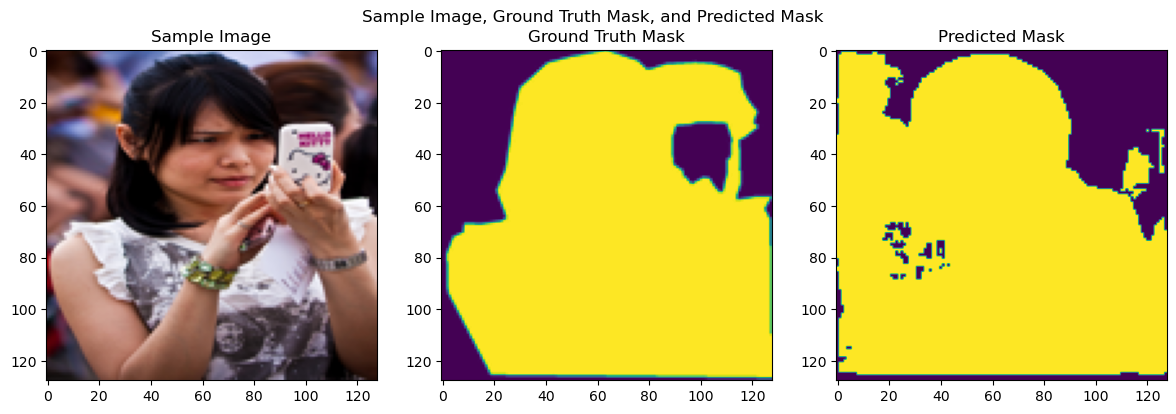

In [11]:
# Select a random index from the batch
idx = np.random.randint(0, sample_images.shape[0])

# Plot the sample image, ground truth mask, and predicted mask
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot sample image
axes[0].imshow(sample_images[idx])
axes[0].set_title('Sample Image')

# Plot ground truth mask
axes[1].imshow(sample_masks[idx])
axes[1].set_title('Ground Truth Mask')

# Plot predicted mask
axes[2].imshow(thresholded_predictions[idx])
axes[2].set_title('Predicted Mask')

# Set common title for the figure
fig.suptitle('Sample Image, Ground Truth Mask, and Predicted Mask')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
iou_metric = MeanIoU(num_classes=2)

# Loop through the entire validation generator
for i in range(len(val_generator)):
    # Get a batch of validation data
    val_images, val_masks = val_generator[i]

    # Make predictions
    preds = inference_model.predict(val_images)

    # Threshold the predictions to binary masks
    preds_thresholded = (preds > 0.5).astype(np.int32)  # You can change threshold if needed

    # Convert ground truths to int if needed
    val_masks_int = val_masks.astype(np.int32)

    # Update the MeanIoU metric with current batch
    iou_metric.update_state(val_masks_int, preds_thresholded)

# Retrieve final IoU score
mean_iou_result = iou_metric.result().numpy()
print(f"\n📊 Mean IoU: {mean_iou_result:.4f}")


In [16]:
print(f"\n📊 Mean IoU: {mean_iou_result:.4f}")


📊 Mean IoU: 0.8010
